In [2]:
# Check for using GPU
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [39]:

train_dir = "Ships dataset/train/"
test_dir = "Ships dataset/test/"
valid_dir = "Ships dataset/valid/"


In [40]:
# helper_function.py - helping functions
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
from tensorflow.keras.layers.experimental import preprocessing
import zipfile

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
    # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# correct horizontal labels verticallt
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

    Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
            xlabel="Predicted label",
            ylabel="True label",
            xticks=np.arange(n_classes), # create enough axis slots for each class
            yticks=np.arange(n_classes),
            xticklabels=labels, # axes will labeled with class names (if they exist) or ints
            yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Change - plot x labels vertically #
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);


def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.

    Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

    Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


# create a function to compare training history
def compare_history(original_history, new_history, initial_epochs=10):
    """
    Compare history of TensorFlow training
    """
    #original history data
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    #new history data
    new_acc = new_history.history["accuracy"]
    new_loss = new_history.history["loss"]
    new_val_acc = new_history.history["val_accuracy"]
    new_val_loss = new_history.history["val_loss"]

    total_acc = acc + new_acc
    total_loss = loss + new_loss
    total_val_acc = val_acc + new_val_acc
    total_val_loss = val_loss + new_val_loss

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training accuracy")
    plt.plot(total_val_acc, label="Validation accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.title("Training and Validation Accuracy")
    plt.legend(loc="lower right")
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training loss")
    plt.plot(total_val_loss, label="Validation loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
def unzip_data(filename):
    """
    Unzips filename into the current working directory.

    Args:
    filename (str): a filepath to a target zip folder to be unzipped.
    """
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.

    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results


# Extend previous function with augmentation
def create_model(input_shape: tuple,
                 learning_rate=0.001,  # default Adam lr
                 output_classes_num = 101,
                 add_rescale: bool=False,
                 add_augmentation: bool=True,
                 is_mix_precision: bool=True,
                 is_label_one_hot_encoded: bool=True) -> tf.keras.Model:
    # 1. Create base model
    base_model = applications.EfficientNetB0(include_top=False)

    # 2. Freeze the base model
    base_model.trainable = False

    # 3. Create input layer
    inputs = layers.Input(shape=input_shape, name="input_layer")

    x = None

    # 4. Add rescale if required (for ResNet for example)
    if add_rescale:
        x = layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

    # 4.2 Add augmentation layer to the input
    if add_augmentation:
        data_augmentation = keras.Sequential([
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomFlip("vertical"),
            preprocessing.RandomRotation(0.2),
            preprocessing.RandomZoom(0.2),
            preprocessing.RandomHeight(0.2),
            preprocessing.RandomWidth(0.2),
        ], name="data_augmentation")
        x = data_augmentation(inputs)

    if x is None:
        x = inputs

    # 5. Pass inputs to base model
    x = base_model(x)
    print(f"Shape after adding input to the base model: {x.shape}")

    # 6. Average pool the output of the base model
    x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    print(f"Shape after adding pooling layer to the base model: {x.shape}")

    # 7. create activation layer
    if is_mix_precision:
        x = layers.Dense(output_classes_num, name='dense_logits')(x)
        outputs = layers.Activation('softmax', dtype='float32', name='predictions_output_layer')(x)
    else:
        outputs = tf.keras.layers.Dense(output_classes_num, activation="softmax", name="predictions_output_layer")(x)

    # 8 conbine inputs and outputs into the model
    model_0 = tf.keras.Model(inputs, outputs)

    # 9. compile the model
    if is_label_one_hot_encoded:
        _loss = "categorical_crossentropy"
    else:
        _loss = "sparse_categorical_crossentropy"

    model_0.compile(loss=_loss,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=["accuracy"])
    return model_0, base_model

In [41]:
walk_through_dir("Ships dataset")

There are 3 directories and 0 images in 'Ships dataset'.
There are 10 directories and 0 images in 'Ships dataset\test'.
There are 0 directories and 44 images in 'Ships dataset\test\Aircraft Carrier'.
There are 0 directories and 14 images in 'Ships dataset\test\Bulkers'.
There are 0 directories and 90 images in 'Ships dataset\test\Car Carrier'.
There are 0 directories and 48 images in 'Ships dataset\test\Container Ship'.
There are 0 directories and 39 images in 'Ships dataset\test\Cruise'.
There are 0 directories and 42 images in 'Ships dataset\test\DDG'.
There are 0 directories and 16 images in 'Ships dataset\test\Recreational'.
There are 0 directories and 15 images in 'Ships dataset\test\Sailboat'.
There are 0 directories and 38 images in 'Ships dataset\test\Submarine'.
There are 0 directories and 35 images in 'Ships dataset\test\Tug'.
There are 10 directories and 0 images in 'Ships dataset\train'.
There are 0 directories and 792 images in 'Ships dataset\train\Aircraft Carrier'.
There

In [42]:
import tensorflow as tf

IMG_SIZE=(224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)  # do not shuffle test data for prediction analysis
valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)  # do not shuffle test data for prediction analysis


Found 7629 files belonging to 10 classes.
Found 381 files belonging to 10 classes.
Found 689 files belonging to 10 classes.


In [43]:
# get class names
class_names = train_data.class_names
class_names

['Aircraft Carrier',
 'Bulkers',
 'Car Carrier',
 'Container Ship',
 'Cruise',
 'DDG',
 'Recreational',
 'Sailboat',
 'Submarine',
 'Tug']

In [44]:
one_sample = train_data.take(1)
print(one_sample)
for image, label in one_sample:
  print(f"""
        Image shape {image[0].shape}
        Image datatype {image[0].dtype}
        Target class from Food101 (tensor form): {label[0]}
        Class name (str form): {class_names[label[0].numpy().argmax()]}
        """)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

        Image shape (224, 224, 3)
        Image datatype <dtype: 'float32'>
        Target class from Food101 (tensor form): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
        Class name (str form): Cruise
        


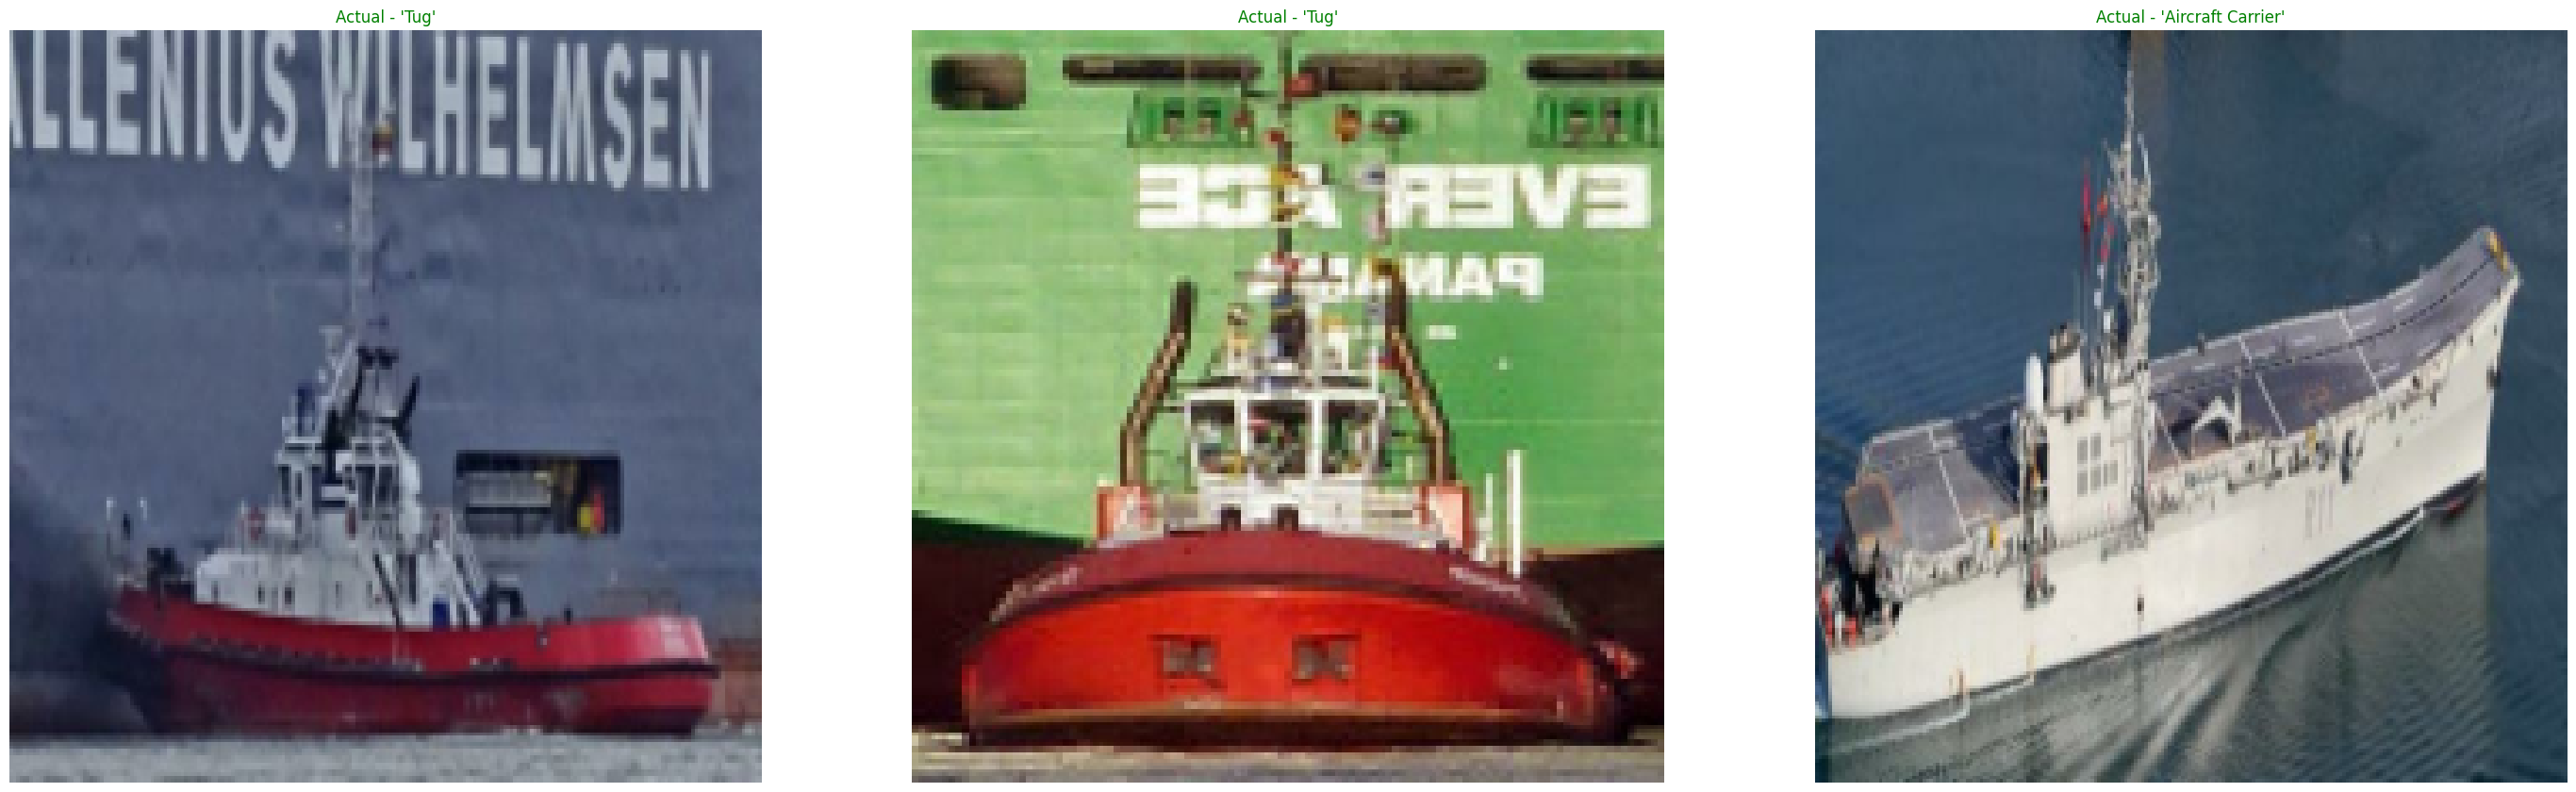

In [45]:
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(35, 35))
for i in range(3):
  class_name_ = random.choice(class_names)
  filename = random.choice(os.listdir(train_dir + "/" + class_name_))
  filepath = train_dir + class_name_ + "/" + filename

  # load the image and make prediction
  img = load_and_prep_image(filename=filepath, scale=False)
  
  # Plot the image
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  title_color = "g"
  plt.title(f"Actual - '{class_name_}'", c=title_color)
  plt.axis(False)

In [46]:
num_classes = len(class_names)
image_size = IMG_SIZE + (3,)

model_1, base_model_1 = create_model(input_shape=image_size,
                                    learning_rate=0.001,
                                    output_classes_num=num_classes,
                                    add_augmentation=False,
                                    add_rescale=False,
                                    is_mix_precision=False,
                                    is_label_one_hot_encoded=True)
model_1.summary()

Shape after adding input to the base model: (None, 7, 7, 1280)
Shape after adding pooling layer to the base model: (None, 1280)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 predictions_output_layer (  (None, 10)                12810     
 Dense)                                                        

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from helper_functions import create_tensorboard_callback

tb_callback = create_tensorboard_callback("tensor_board", "ship_vision")
earlystop_callback = EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)
checkpoint_path = "model_checkpoint/cp.ckpt"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      monitor="val_accuracy",
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

Saving TensorBoard log files to: tensor_board/ship_vision/20231028-204852


In [48]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[tb_callback, earlystop_callback, checkpoint_callback])

Epoch 1/5
239/239 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.8795
Epoch 1: val_accuracy improved from -inf to 0.94488, saving model to model_checkpoint\cp.ckpt
239/239 [==============================] - 428s 2s/step - loss: 0.5281 - accuracy: 0.8795 - val_loss: 0.2260 - val_accuracy: 0.9449
Epoch 2/5
239/239 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9684
Epoch 2: val_accuracy improved from 0.94488 to 0.96063, saving model to model_checkpoint\cp.ckpt
239/239 [==============================] - 390s 2s/step - loss: 0.1634 - accuracy: 0.9684 - val_loss: 0.1589 - val_accuracy: 0.9606
Epoch 3/5
239/239 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9785
Epoch 3: val_accuracy improved from 0.96063 to 0.96325, saving model to model_checkpoint\cp.ckpt
239/239 [==============================] - 387s 2s/step - loss: 0.1120 - accuracy: 0.9785 - val_loss: 0.1397 - val_accuracy: 0.9633
Epoch 4/5
239/239 [============

In [49]:
model_1.evaluate(valid_data)

22/22 [==============================] - 34s 2s/step - loss: 0.0910 - accuracy: 0.9768


[0.09095614403486252, 0.9767779111862183]